In [48]:
# Imports and Function Initialization

import numpy as np
import math
from math import log2, sqrt
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import Initialize
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram
import scipy.stats
import matplotlib.pyplot as plt
from qiskit.circuit.library import RYGate, CCXGate
from collections import deque

In [49]:
# Define global variables for quantum state
num_qubits = 2
num_states = 2**num_qubits
state_step = 1 / num_states

In [50]:
# Here you can create discretized values for ANY distribution, and it should work!

# Get the discretized value for the uniform distribution

# p = []
# for i in range(1, num_states + 1):
#     p.append(1/num_states)

# Get the discretized value for the normal distribution

mean = 0.5
std = 1/6 # Makes the distribution fit within 0 and 1
p = []
for i in range(1, num_states + 1):
    state = i * state_step
    p.append(scipy.stats.norm.cdf(state, mean, std) - scipy.stats.norm.cdf(state - state_step, mean, std))

# Normalize the distribution
p = np.array(p)
p = p / np.sum(p)

print(p)

[0.0656345 0.4343655 0.4343655 0.0656345]


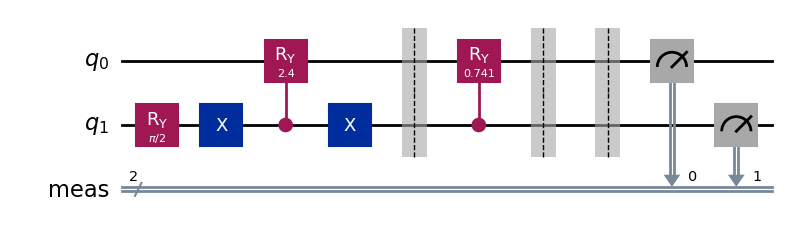

In [ ]:
def create_circuit(p):

    # p = p[::-1]
    qc = QuantumCircuit(num_qubits)

    queue = deque()
    queue.append((p, [], 1))

    while queue:
        curr_p, curr_path, prev_sum = queue.popleft()

        if len(curr_p) == 1:
            continue
        
        mid = len(curr_p) // 2
        left_sum = sum(curr_p[:mid])
        theta = 2 * np.arccos(np.sqrt(left_sum / prev_sum))

        if len(curr_path) == 0:
            qc.ry(theta, num_qubits - 1) 
        else:
            control_qubits = [num_qubits - 1 - i for i in range(len(curr_path))]  
            not_gates = []
            for i in range(len(curr_path)):
                if curr_path[i]:
                    not_gates.append(control_qubits[i])
            qc.x(not_gates) if not_gates else None
            qc.append(RYGate(theta).control(len(curr_path)), 
                      control_qubits + [num_qubits - 1 - len(curr_path)])  
            qc.x(not_gates) if not_gates else None

        qc.barrier()
        
        queue.append((curr_p[:mid], curr_path + [True], left_sum))
        queue.append((curr_p[mid:], curr_path + [False], prev_sum - left_sum))

    qc.measure_all()
    return qc

qc = create_circuit(p)
print(qc.draw(output="latex_source")) # Get LATEX code
qc.draw('mpl')

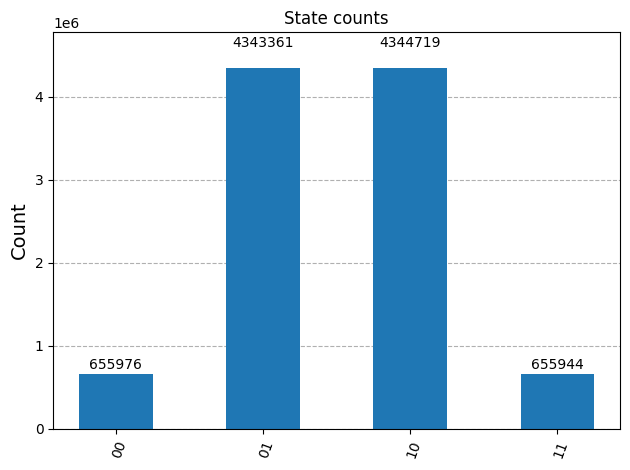

In [52]:
from qiskit_aer import AerSimulator

simulator = AerSimulator()
qc_t = transpile(qc, simulator)
result = simulator.run(qc_t,shots=10000000).result()
counts = result.get_counts(qc_t)
plot_histogram(counts, title='State counts')